In [1]:
!pip install albumentations==0.4.6
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=ca42ca967b053e4c9b678252c31e3c3ee1e25687e62a9cad8ab0b9faa6a1dac1
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.14
    Uninstalling albumentations-1.4.14:
      Successfully uninstalled albumentations-1.4.14
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 8.0 MB/s eta 0:00:00:00:010:01


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


In [3]:
# Albumentations Augmentation Pipeline for DAWN Dataset
def get_dawn_augmentation_pipeline():
    return A.Compose([
        A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.4, alpha_coef=0.1, p=0.5),  # Fog enhancement
        A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.4, brightness_coeff=2.5, p=0.5),  # Snow enhancement
        A.RandomRain(brightness_coefficient=0.9, drop_length=8, blur_value=3, p=0.5),  # Rain enhancement
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.Resize(416, 416),  # Consistent input size
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])



In [4]:
# Dataset for DAWN with Augmentations
class DAWNDataset(Dataset):
    def __init__(self, root_dir, augment=True):
        # Adjusting for the extra 'DAWN' folder
        self.root_dir = os.path.join(root_dir, 'DAWN')
        self.augment = augment
        self.image_paths = []
        self.labels = []
        self.conditions = ['Fog', 'Rain', 'Sand', 'Snow']

        # Collect all images and labels from different weather conditions
        self._process_dawn_dataset()

        self.transform = get_dawn_augmentation_pipeline() if self.augment else None

    def _process_dawn_dataset(self):
        for condition in self.conditions:
            condition_dir = os.path.join(self.root_dir, condition, condition)
            if os.path.exists(condition_dir):
                print(f"Processing condition: {condition}")
                for img_file in os.listdir(condition_dir):
                    if img_file.endswith(('.jpg', '.png')):
                        img_path = os.path.join(condition_dir, img_file)
                        label_path = os.path.join(condition_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

                        # Ensure the image and label paths exist
                        if os.path.exists(img_path):
                            self.image_paths.append(img_path)
                            if os.path.exists(label_path):
                                self.labels.append(label_path)
                            else:
                                self.labels.append(None)
                        else:
                            print(f"Image path does not exist: {img_path}")
            else:
                print(f"Condition directory not found: {condition_dir}")

        if len(self.image_paths) == 0:
            print("No images found in the dataset.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label


In [5]:
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss,
    }
    torch.save(state, filename)


In [6]:

# Function to display a few images before training
def visualize_augmentations(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, _ = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# All-Weather Image Enhancement Network (AWIE)
class AWIE(nn.Module):
    def __init__(self):
        super(AWIE, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(3, 64),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            self.conv_block(256, 512),
        )
        self.decoder = nn.Sequential(
            self.conv_block(512, 256, transpose=True),
            self.conv_block(256, 128, transpose=True),
            self.conv_block(128, 64, transpose=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def conv_block(self, in_channels, out_channels, transpose=False):
        if not transpose:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)



In [7]:
# Train AWIE and plot loss
def train_awie(model, dataloader, num_epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    model.to(device)

    losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_idx, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            inputs_resized = F.interpolate(inputs, size=outputs.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, inputs_resized)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), losses, label="AWIE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



In [8]:
# Evaluation Metrics (Precision, Recall, F1-Score)
def evaluate_yolo(yolo_model, dataloader, device):
    yolo_model.to(device)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            preds = yolo_model(inputs)

            # Extract predictions and labels (assuming labels are in YOLO format)
            for pred, label in zip(preds, labels):
                boxes = pred.boxes.xyxy.cpu().numpy()  # Convert to NumPy array
                all_preds.extend(boxes)
                # Add logic to extract actual labels from the label files
                # Example: assuming label is in format (class, x1, y1, x2, y2)
                with open(label, 'r') as f:
                    ground_truth = [list(map(float, line.strip().split())) for line in f.readlines()]
                all_labels.extend(ground_truth)

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


In [9]:
def fine_tune_yolov8(awie_model, yolo_model, dataloader, num_epochs, device):
    yolo_model.to(device)
    optimizer = optim.Adam(yolo_model.parameters(), lr=1e-4)  # Define optimizer
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            enhanced_inputs = awie_model(inputs)  # Apply AWIE enhancement

            print(f"Enhanced Inputs Shape: {enhanced_inputs.shape}")
            results = yolo_model(enhanced_inputs)

            # Ensure results contains the expected structure
            if hasattr(results, 'loss'):
                loss = results.loss
            else:
                print(f"Unexpected results structure: {results}")
                continue  # Skip this batch if results are not as expected

            optimizer.zero_grad()
            if loss is not None:
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
            else:
                print(f"Loss is None at batch {batch_idx}")

        avg_loss = epoch_loss / len(dataloader) if len(dataloader) > 0 else 0
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], YOLOv8 Loss: {avg_loss:.4f}")

    # Plot YOLOv8 training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), losses, label="YOLOv8 Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [10]:
def visualize_predictions(yolo_model, dataloader, device):
    yolo_model.to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            preds = yolo_model(inputs)

            # Assuming preds contain bounding boxes
            for img, pred in zip(inputs, preds):
                # Convert img to numpy and display with predictions
                img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy
                plt.imshow(img_np)
                for box in pred.boxes.xyxy:  # Modify based on actual structure
                    x1, y1, x2, y2 = box.cpu().numpy()
                    plt.rectangle([x1, y1], [x2, y2], color='red', linewidth=2)  # Draw boxes
                plt.axis('off')
                plt.show()


In [11]:
# Main training loop for DAWN dataset
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Root directory for DAWN dataset
    dawn_root_dir = "/kaggle/input/dawn-low-visibilty-car-detection/"

    # Create dataset for DAWN with augmentations
    dawn_dataset = DAWNDataset(dawn_root_dir, augment=True)
    dataloader = DataLoader(dawn_dataset, batch_size=32, shuffle=True, num_workers=4)

    # Visualize some augmented images
    visualize_augmentations(dawn_dataset)

    # Train the AWIE model for DAWN dataset
    awie_model = AWIE()
    train_awie(awie_model, dataloader, num_epochs=50, device=device)

    # Load pre-trained YOLOv8 and fine-tune on DAWN dataset
    yolo_model = YOLO('yolov8n.pt')
    fine_tune_yolov8(awie_model, yolo_model, dataloader, num_epochs=20, device=device)

    # Save models
    torch.save(awie_model.state_dict(), 'awie_dawn_model.pth')
    yolo_model.save('fine_tuned_yolov8_dawn.pt')

    # Evaluate YOLO performance
    evaluate_yolo(yolo_model, dataloader, device)

    # Visualize YOLO predictions on sample images
    visualize_predictions(yolo_model, dataloader, device)


Processing condition: Fog
Processing condition: Rain
Processing condition: Sand
Processing condition: Snow


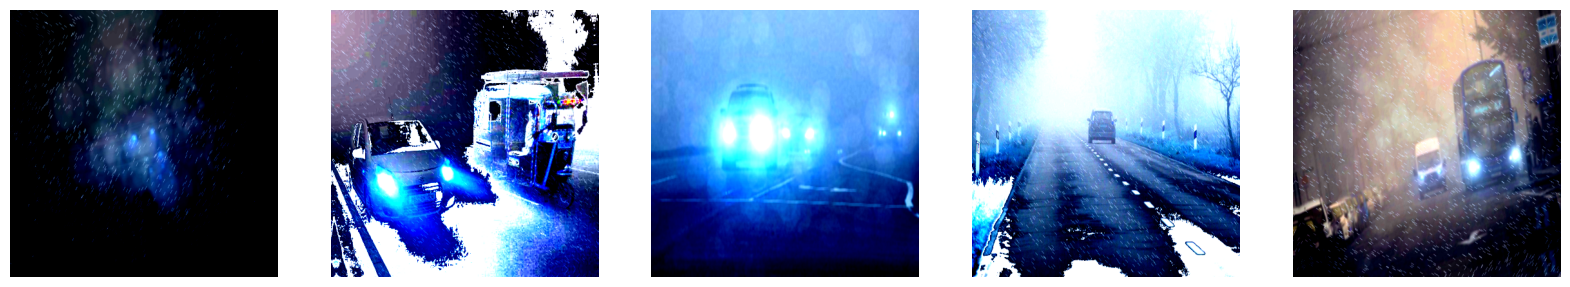

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 174, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 174, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 192, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>


In [12]:
if __name__ == "__main__":
    main()
